In [1]:
from helper import split_name
from read_data import pull_data, prepare_data, get_expert_projections
from modeling import split_data_random, create_baseline, tune_xgb, create_model, generate_prediction_intervals, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, finalize_predictions, create_draft_pool, calculate_relative_value, determine_optimal_k, segment_players
from config import AGG_YEARS, SCORING_RULES, batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, param_space, POS_DAMPENING_MAP
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

FORMAT = "UD" # <- Indicator for scoring format ("UD" for Underdog, "DK" for DraftKings, etc.)
START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
MODEL_WEIGHT = 0.67
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.34
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.33
SEED = 61255418

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

C:\Users\jorda\Documents\development\baseball_modeling\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [3]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
    fmt=FORMAT
)

# Prepare data for modeling
batting_df, pitching_df, batting_pred, pitching_pred = prepare_data(
    batting_df,
    pitching_df,
    pred_season=END_YEAR,
)

Loaded existing UD data files.


In [4]:
# TODO: Fix up n_estimators documentation
# TODO: Switch pitching model to RMSE-based?
# TODO: Code cleanup/organization

# Pulling FantasyPros Projection Data

In [5]:
batting_projections, pitching_projections = get_expert_projections(
    batting_url=batting_url,
    pitching_url=pitching_url,
    fmt=FORMAT,
    scoring_rules=SCORING_RULES,
)

# Creating Batting Model

## Creating baseline batting predictions

In [6]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data_random(batting_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

# Compiling baseline predictions
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp.head(10))

[Test] RMSE: 303.674 | MAE: 239.014 | R^2: 0.501 | Spearman: 0.693


,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
513,Miguel Cabrera,1522.0,1630.756592,108.756592,108.756592,2007,24,1606.0
529,Jimmy Rollins,1345.0,1594.728149,249.728149,249.728149,2007,28,1858.0
200,Jason Bay,1175.0,1592.571045,417.571045,417.571045,2006,27,1630.0
351,Jose Reyes,332.0,1585.354614,1253.354614,1253.354614,2008,25,1717.0
429,Albert Pujols,1808.0,1582.721680,-225.278320,225.278320,2009,29,1981.0
179,Paul Goldschmidt,1719.0,1575.689575,-143.310425,143.310425,2016,28,1679.0
762,Mike Trout,1790.0,1571.406372,-218.593628,218.593628,2015,23,1667.0
675,David Ortiz,1129.0,1566.820068,437.820068,437.820068,2007,31,1775.0
697,Miguel Cabrera,1575.0,1554.994873,-20.005127,20.005127,2008,25,1522.0
527,Miguel Cabrera,1762.0,1534.042603,-227.957397,227.957397,2011,28,1718.0


# Building Batting Model

# Batting Predictions

In [ ]:
# Tune model
best_params, best_iter = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=param_space,
    model_objective="reg:absoluteerror",
    metric="mae",     
    evals=50,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
batting_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=batting_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    model_objective="reg:absoluteerror",
    metric="mae",
    n_bootstrap=40,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2000,
    early_stopping_rounds=100,
)

  8%|▊         | 4/50 [00:36<07:42, 10.05s/trial, best loss: 228.11600917600236]

In [ ]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    n_estimators=best_iter,
    model_objective="reg:absoluteerror",
    metric="mae",
    random_state=SEED,
    id_cols=["IDfg"],        
)

[Test] RMSE: 308.779 | MAE: 235.172 | R^2: 0.483 | SPEAR: 0.705


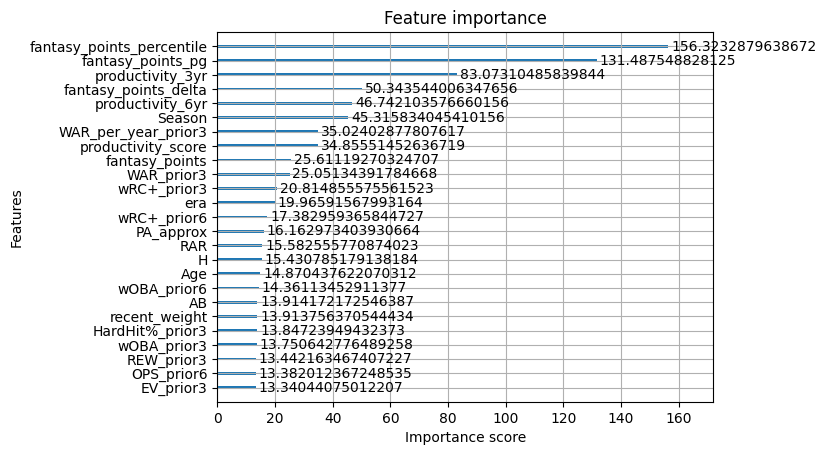

In [ ]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [ ]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
127,Prince Fielder,1515.0,1670.021240,155.021240,155.021240,2009,25,1826.0
686,Jose Reyes,332.0,1633.336914,1301.336914,1301.336914,2008,25,1717.0
434,Grady Sizemore,1058.0,1631.455200,573.455200,573.455200,2008,25,1744.0
476,Mike Trout,1822.0,1608.939819,-213.060181,213.060181,2012,20,1716.0
134,Derrek Lee,460.0,1595.305664,1135.305664,1135.305664,2005,29,1868.0
268,Ryan Howard,1362.0,1566.656494,204.656494,204.656494,2009,29,1729.0
229,Mark Teixeira,1607.0,1562.753662,-44.246338,44.246338,2005,25,1798.0
248,Miguel Cabrera,1708.0,1548.937744,-159.062256,159.062256,2009,26,1575.0
212,Paul Goldschmidt,1143.0,1496.634521,353.634521,353.634521,2013,25,1743.0
437,Miguel Cabrera,1174.0,1492.824951,318.824951,318.824951,2014,31,1522.0


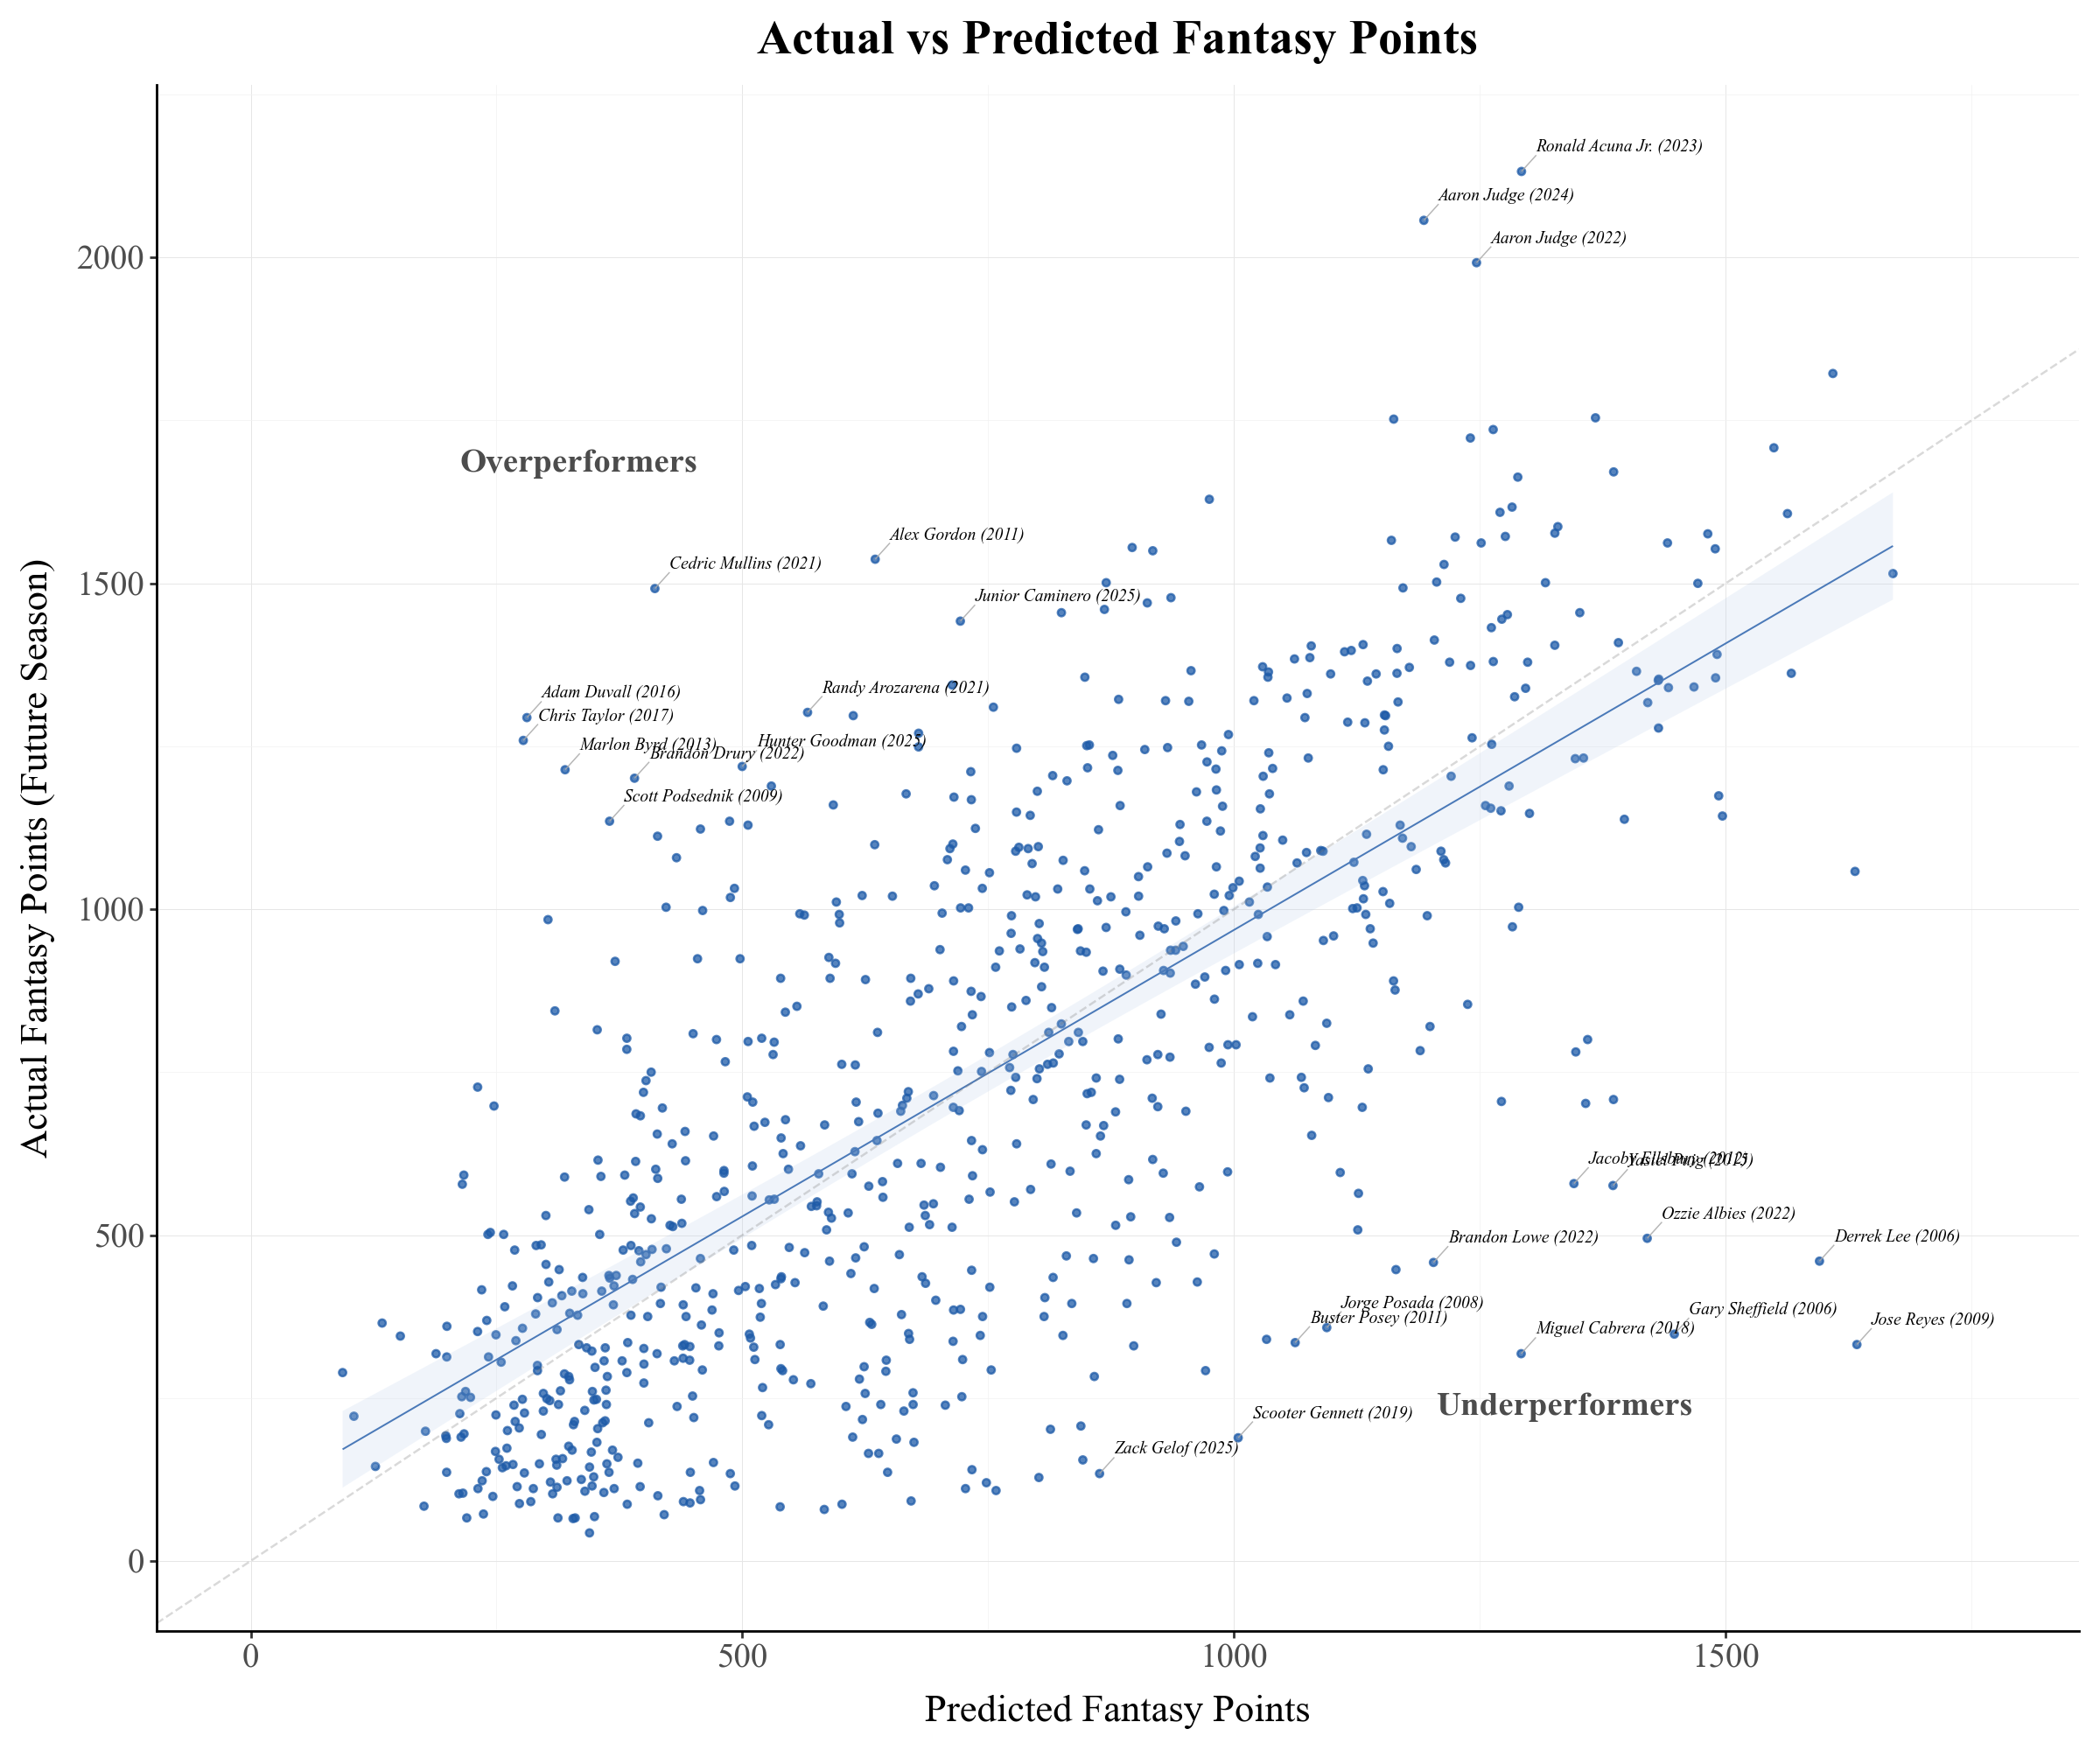

In [ ]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

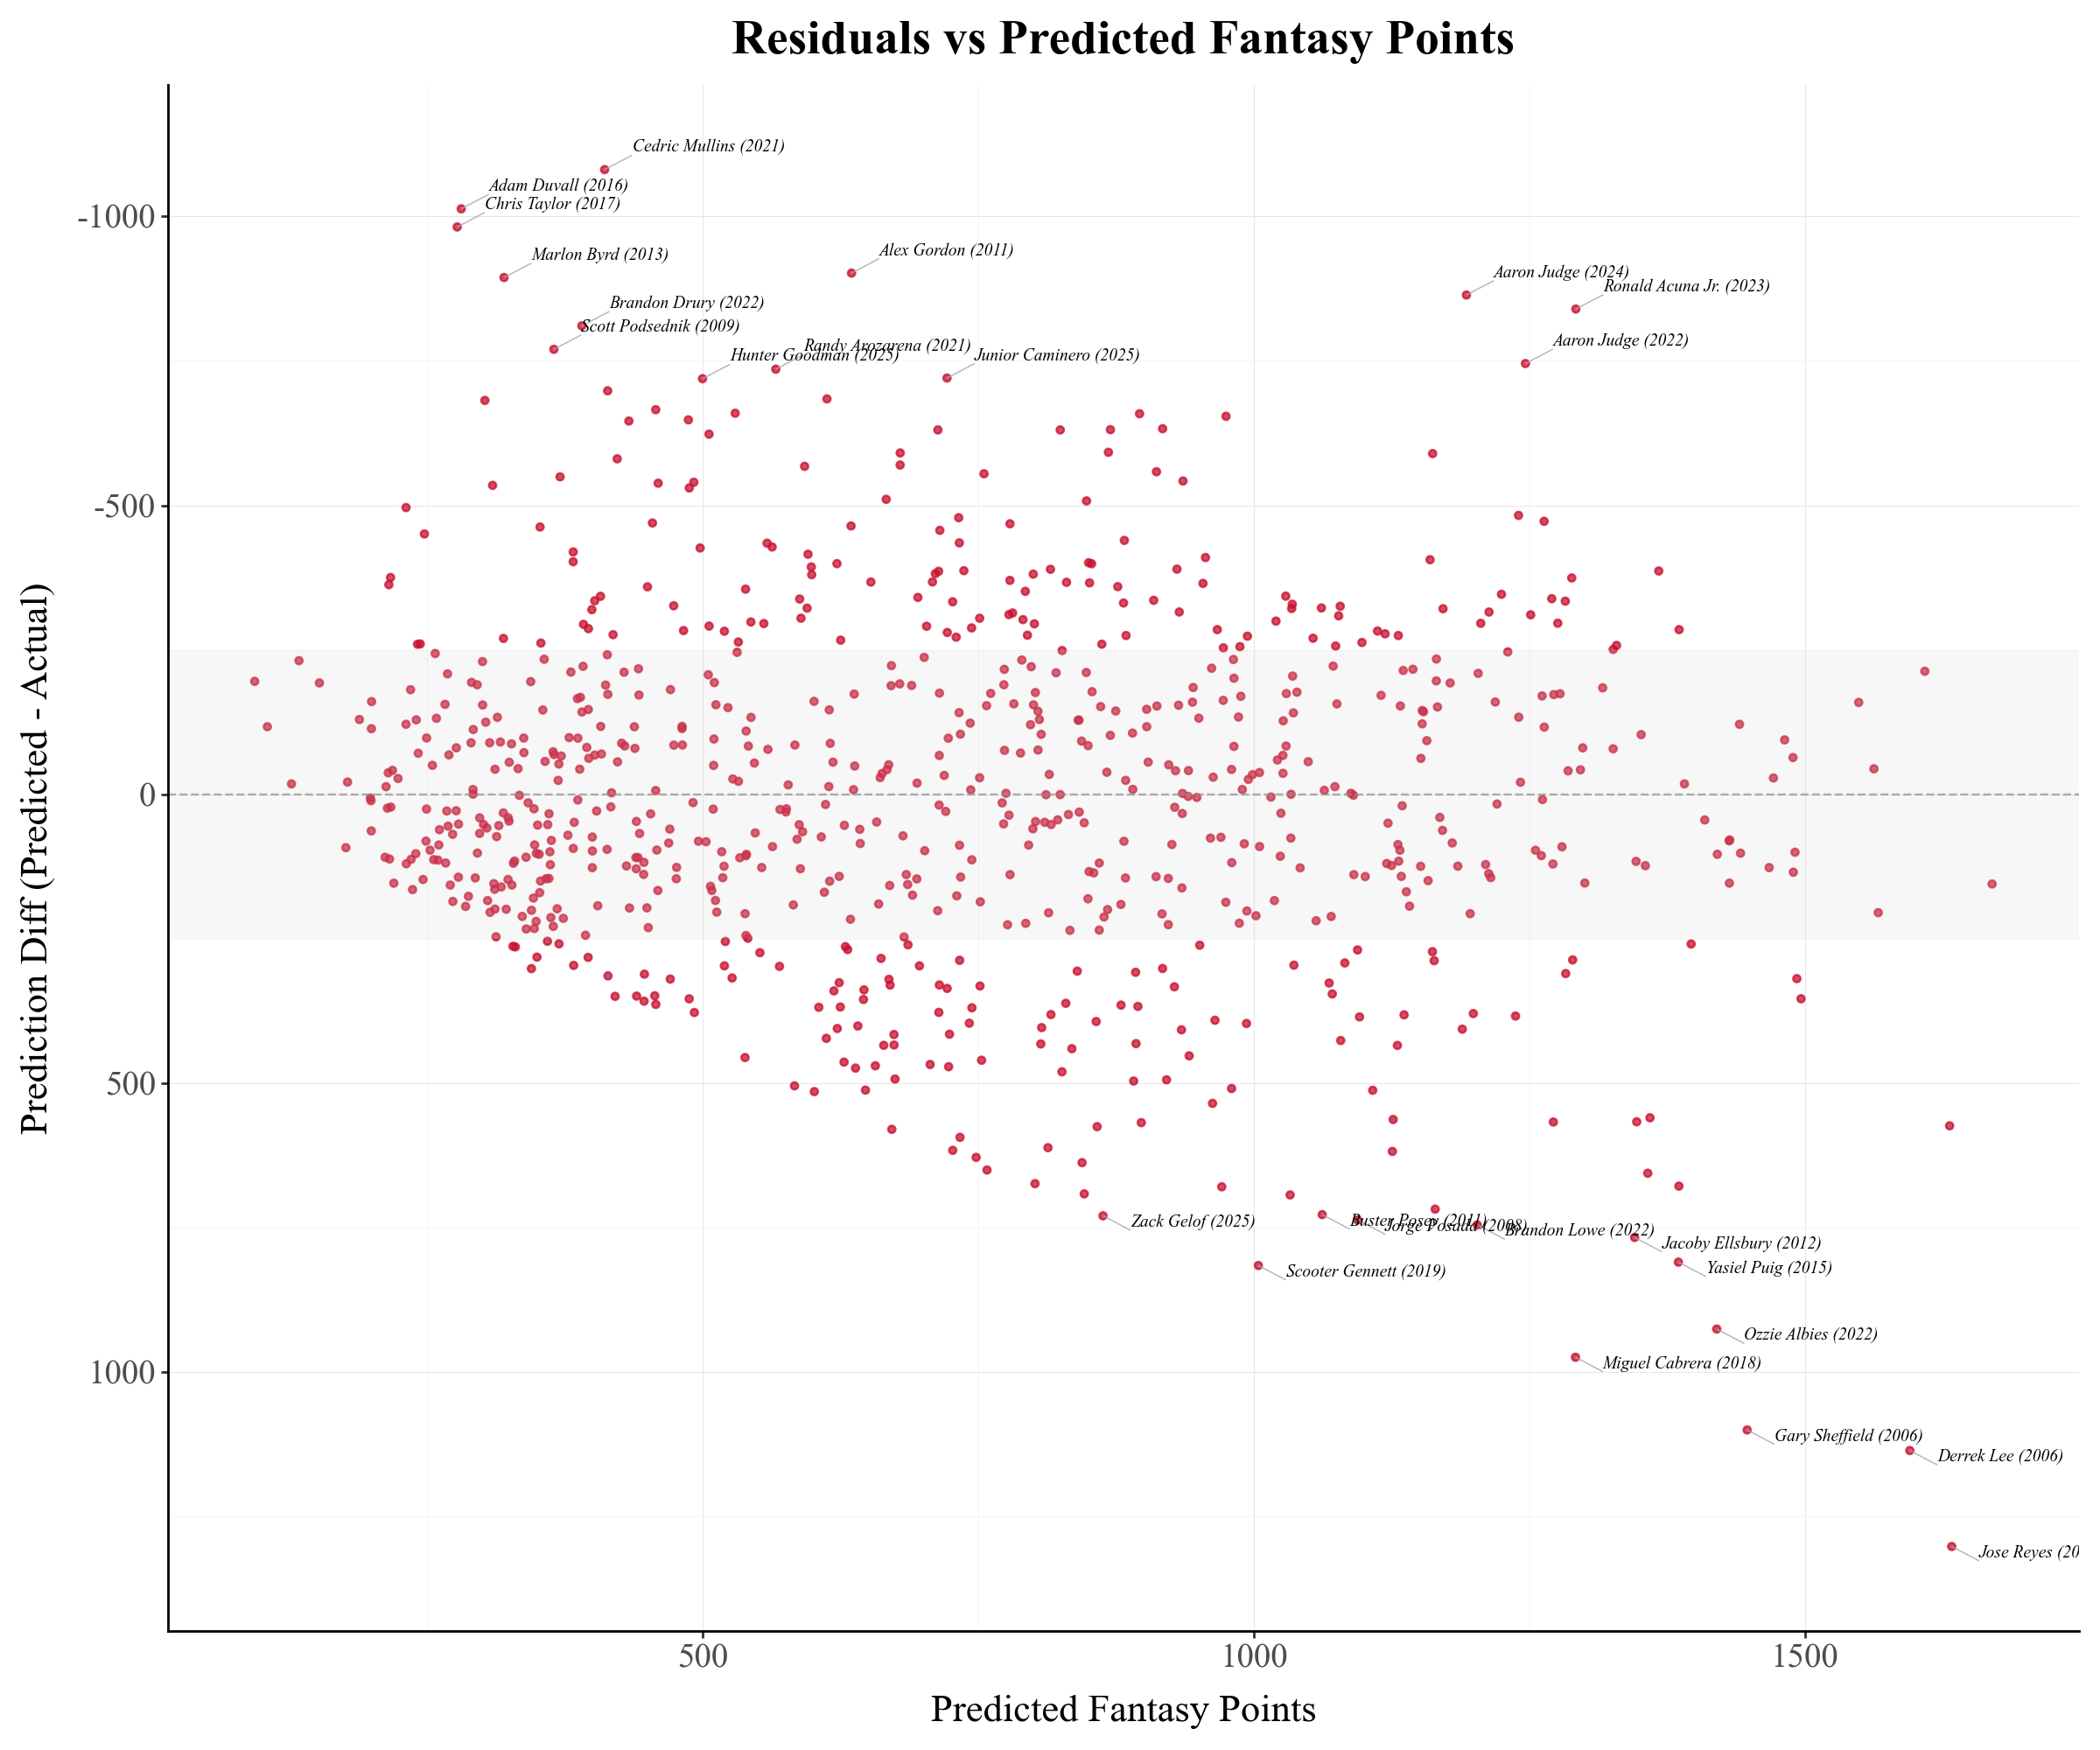

In [ ]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=25,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

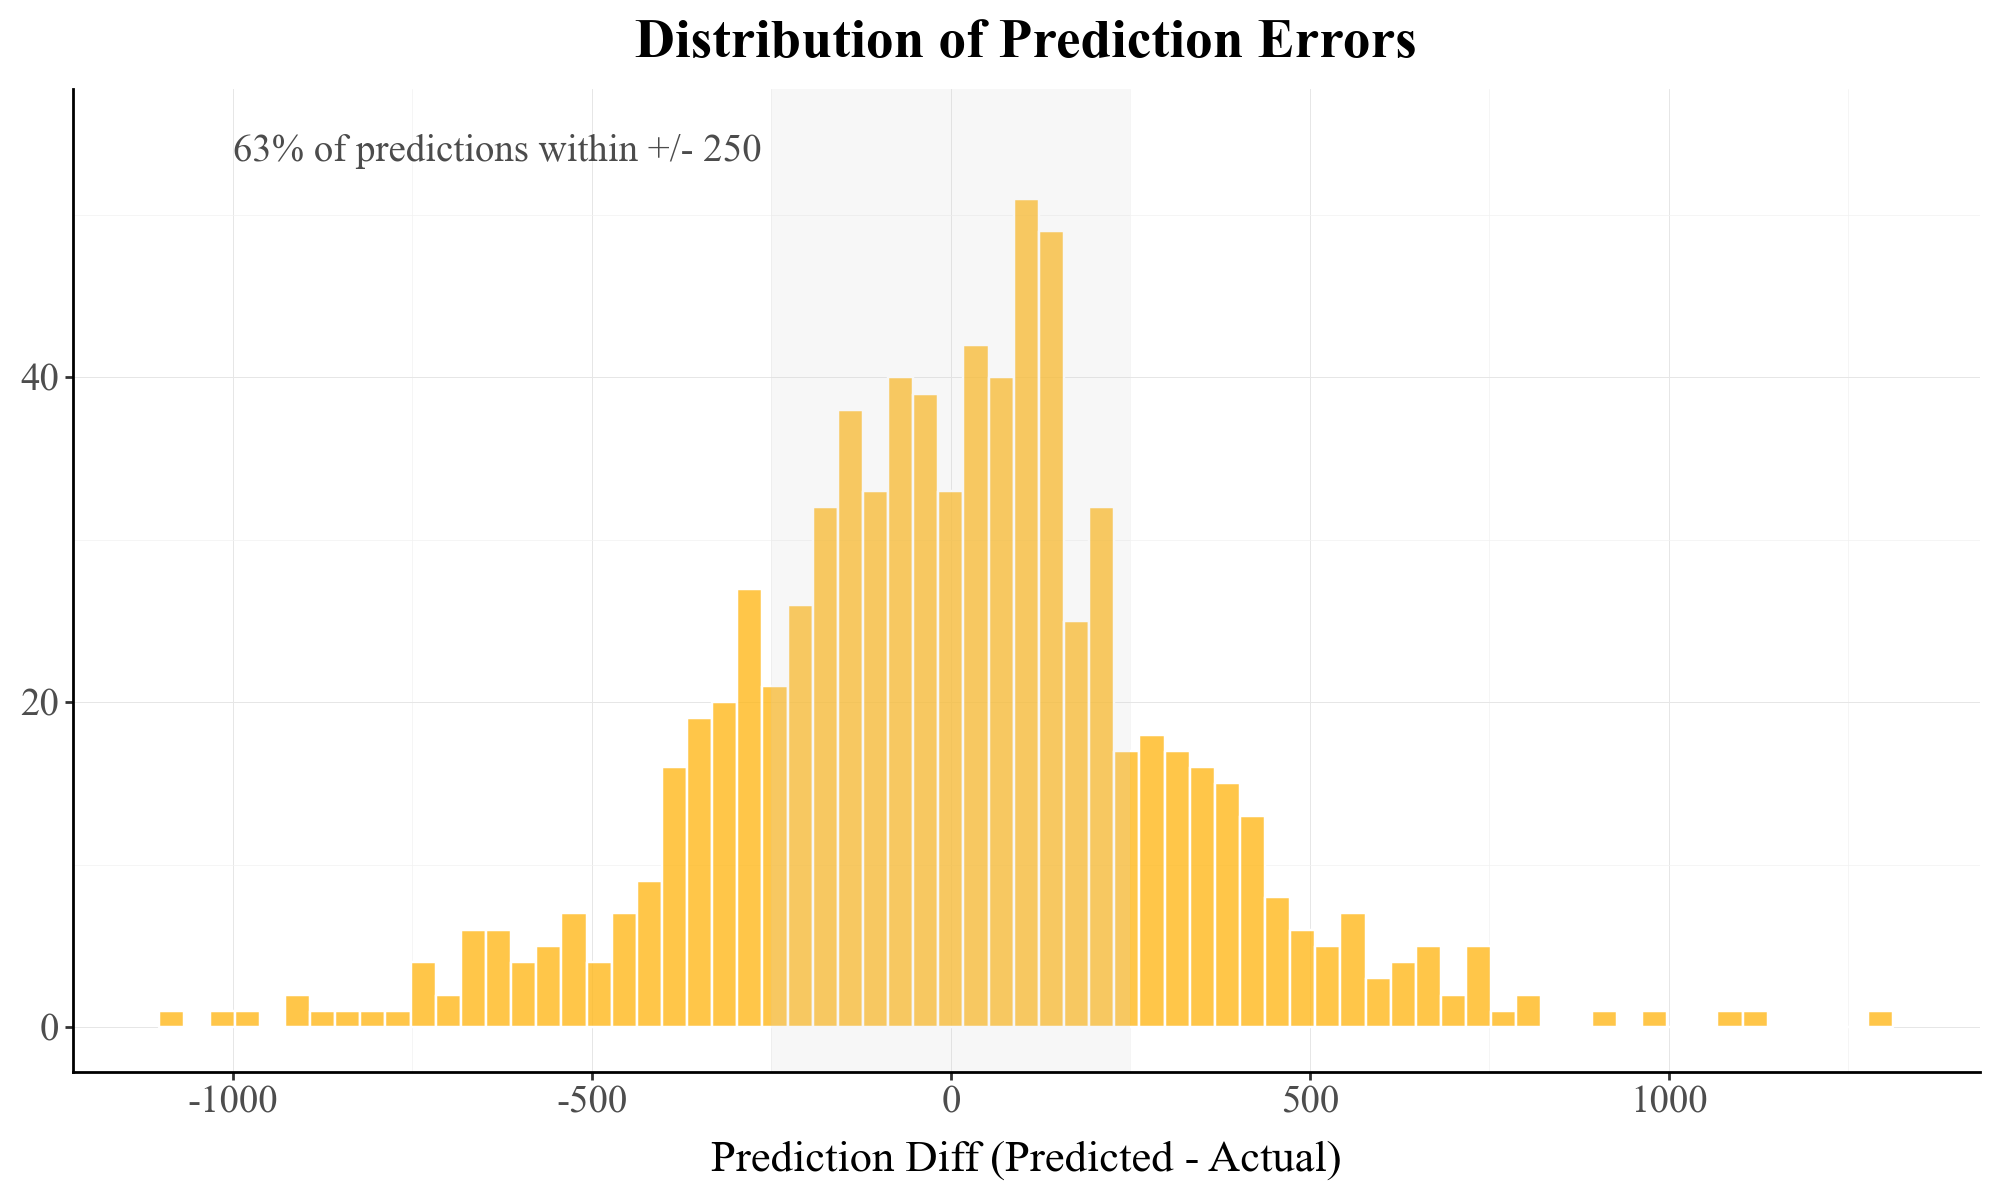

In [ ]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=35,
    x_annotate=-1000,    # custom annotation position
    y_annotate=55,      # custom annotation position
)
p3.show()

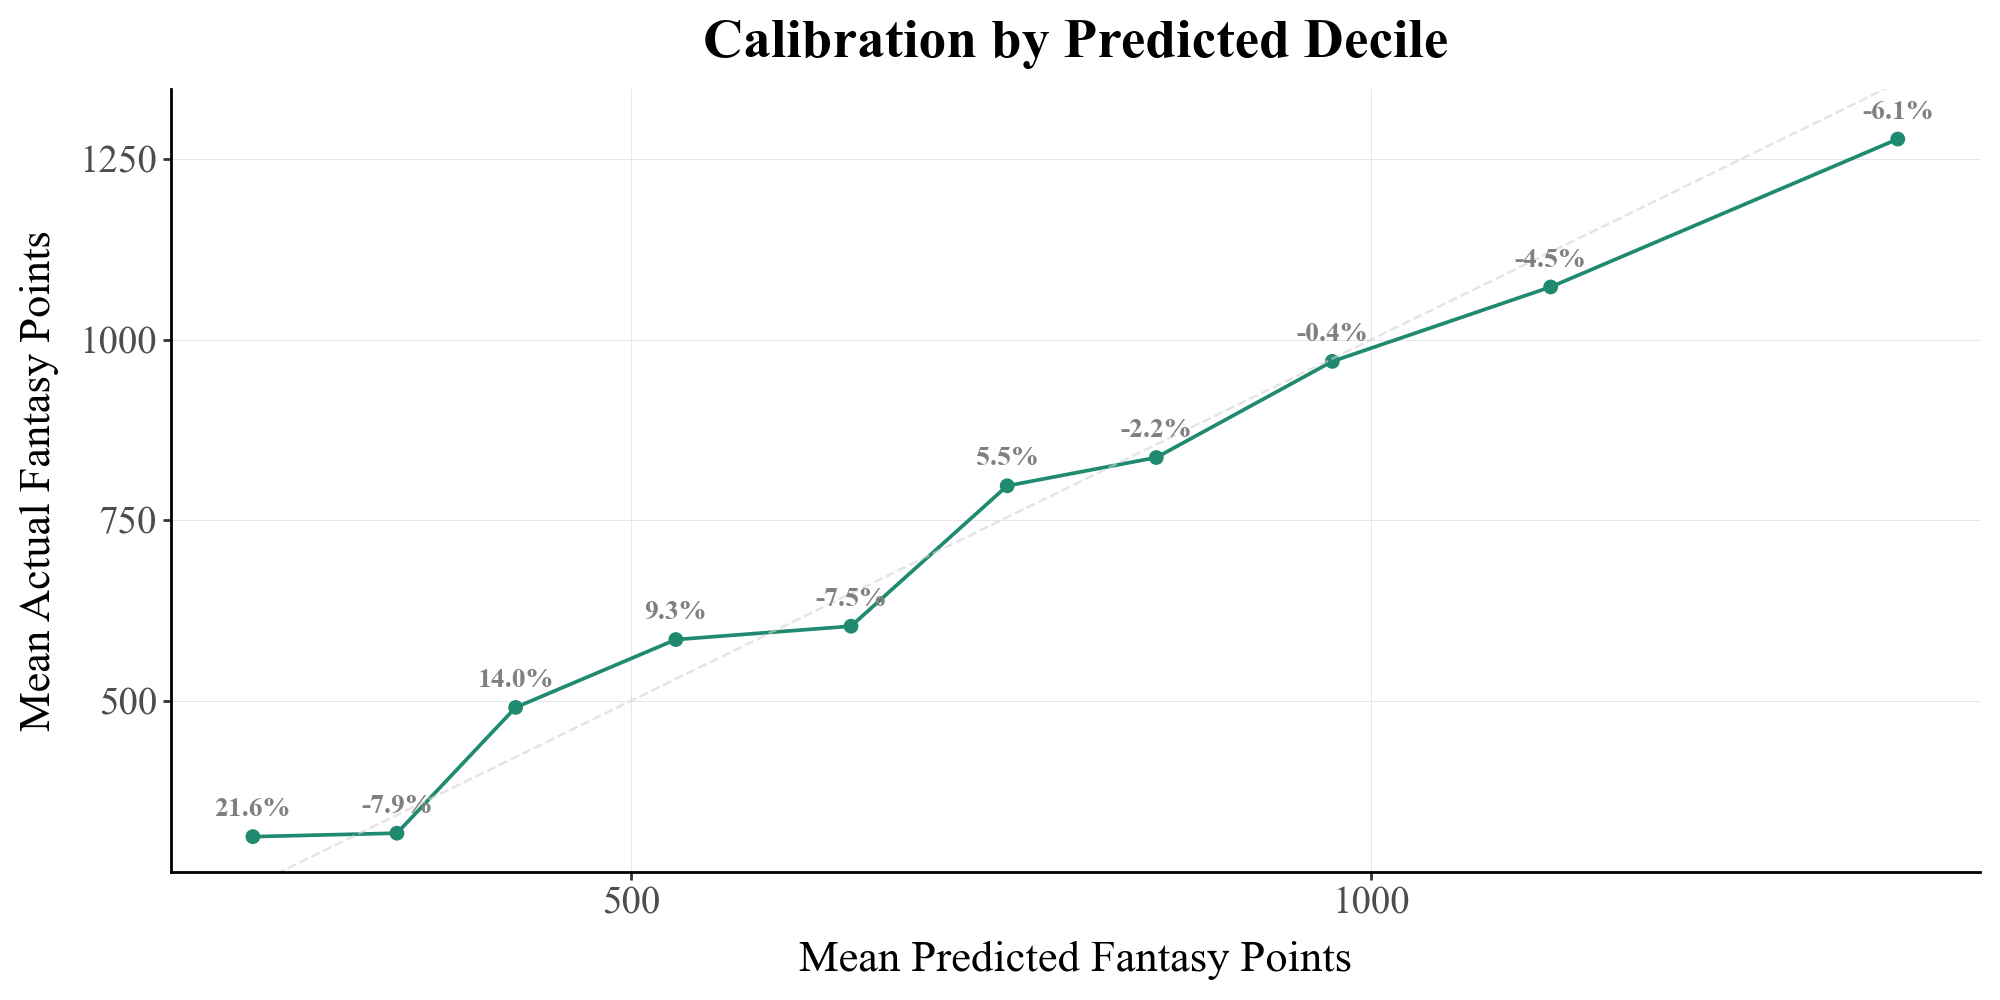

In [ ]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating Pitching Model

# Creating baseline pitching predictions

In [ ]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data_random(pitching_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 210.285 | MAE: 156.178 | R^2: 0.399 | Spearman: 0.569


In [ ]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
379,Madison Bumgarner,533.0,1317.571411,784.571411,784.571411,2016,26,1299.6
488,Justin Verlander,1167.3,1216.813232,49.513232,49.513232,2009,26,1346.0
309,David Price,1153.0,1192.372437,39.372437,39.372437,2015,29,1245.3
243,David Price,1168.0,1115.640259,-52.359741,52.359741,2011,25,1125.3
308,Sandy Alcantara,785.6,1080.661865,295.061865,295.061865,2022,26,1201.6
630,Mark Prior,143.6,1060.393188,916.793188,916.793188,2005,24,913.6
76,Stephen Strasburg,746.0,1045.850952,299.850952,299.850952,2017,28,1065.3
138,Corey Kluber,160.6,1034.904419,874.304419,874.304419,2018,32,1204.0
290,Ubaldo Jimenez,860.3,1009.768921,149.468921,149.468921,2010,26,1187.6
370,Kevin Gausman,868.0,998.465454,130.465454,130.465454,2023,32,1131.0


# Pitching Predictions

In [ ]:
# Tune model
best_params, best_iter = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=param_space,
    model_objective="reg:squarederror",
    metric="rmse",     
    evals=50,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
pitching_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=pitching_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    model_objective="reg:squarederror",
    metric="rmse",
    n_bootstrap=40,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2000,
    early_stopping_rounds=100,
)

100%|██████████| 50/50 [02:53<00:00,  3.48s/trial, best loss: 189.99549984129675]
[Early stopping summary] mean=157, min=73, max=427
Best Parameters: {'learning_rate': 0.06392770344698975, 'max_leaves': 13, 'grow_policy': 'lossguide', 'subsample': 0.8355008875870878, 'colsample_bytree': 0.72824112808326, 'min_child_weight': 0.8257955185036107, 'reg_lambda': 0.07660927394987992, 'reg_alpha': 5.093620025057274, 'gamma': 0.0005267722522977498}
[Best trial @ val] optimized=rmse | RMSE=189.995 | MAE=141.680 | R^2=0.568 | SPEAR=0.648 


Bootstrapping prediction intervals: 100%|██████████| 40/40 [01:05<00:00,  1.65s/it]


In [ ]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    n_estimators=best_iter,
    model_objective="reg:squarederror",
    metric="rmse",
    random_state=SEED,
    id_cols=["IDfg"],          
)

[Test] RMSE: 201.115 | MAE: 150.491 | R^2: 0.451 | SPEAR: 0.594


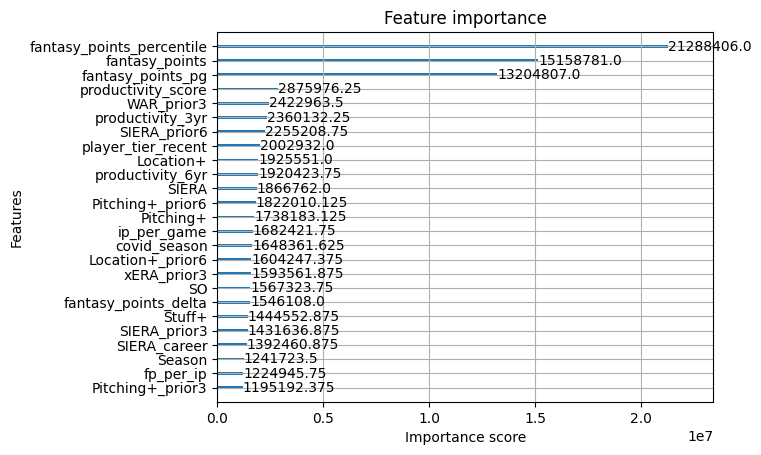

In [ ]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [ ]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
379,Madison Bumgarner,533.0,1123.303589,590.303589,590.303589,2016,26,1299.6
309,David Price,1153.0,1107.546997,-45.453003,45.453003,2015,29,1245.3
488,Justin Verlander,1167.3,1106.626953,-60.673047,60.673047,2009,26,1346.0
243,David Price,1168.0,1094.378540,-73.621460,73.621460,2011,25,1125.3
290,Ubaldo Jimenez,860.3,1054.835205,194.535205,194.535205,2010,26,1187.6
308,Sandy Alcantara,785.6,1031.221802,245.621802,245.621802,2022,26,1201.6
630,Mark Prior,143.6,990.912781,847.312781,847.312781,2005,24,913.6
76,Stephen Strasburg,746.0,988.292847,242.292847,242.292847,2017,28,1065.3
348,Dan Haren,1186.3,964.132874,-222.167126,222.167126,2008,27,1106.0
210,Yovani Gallardo,1055.0,956.371948,-98.628052,98.628052,2011,25,1084.3


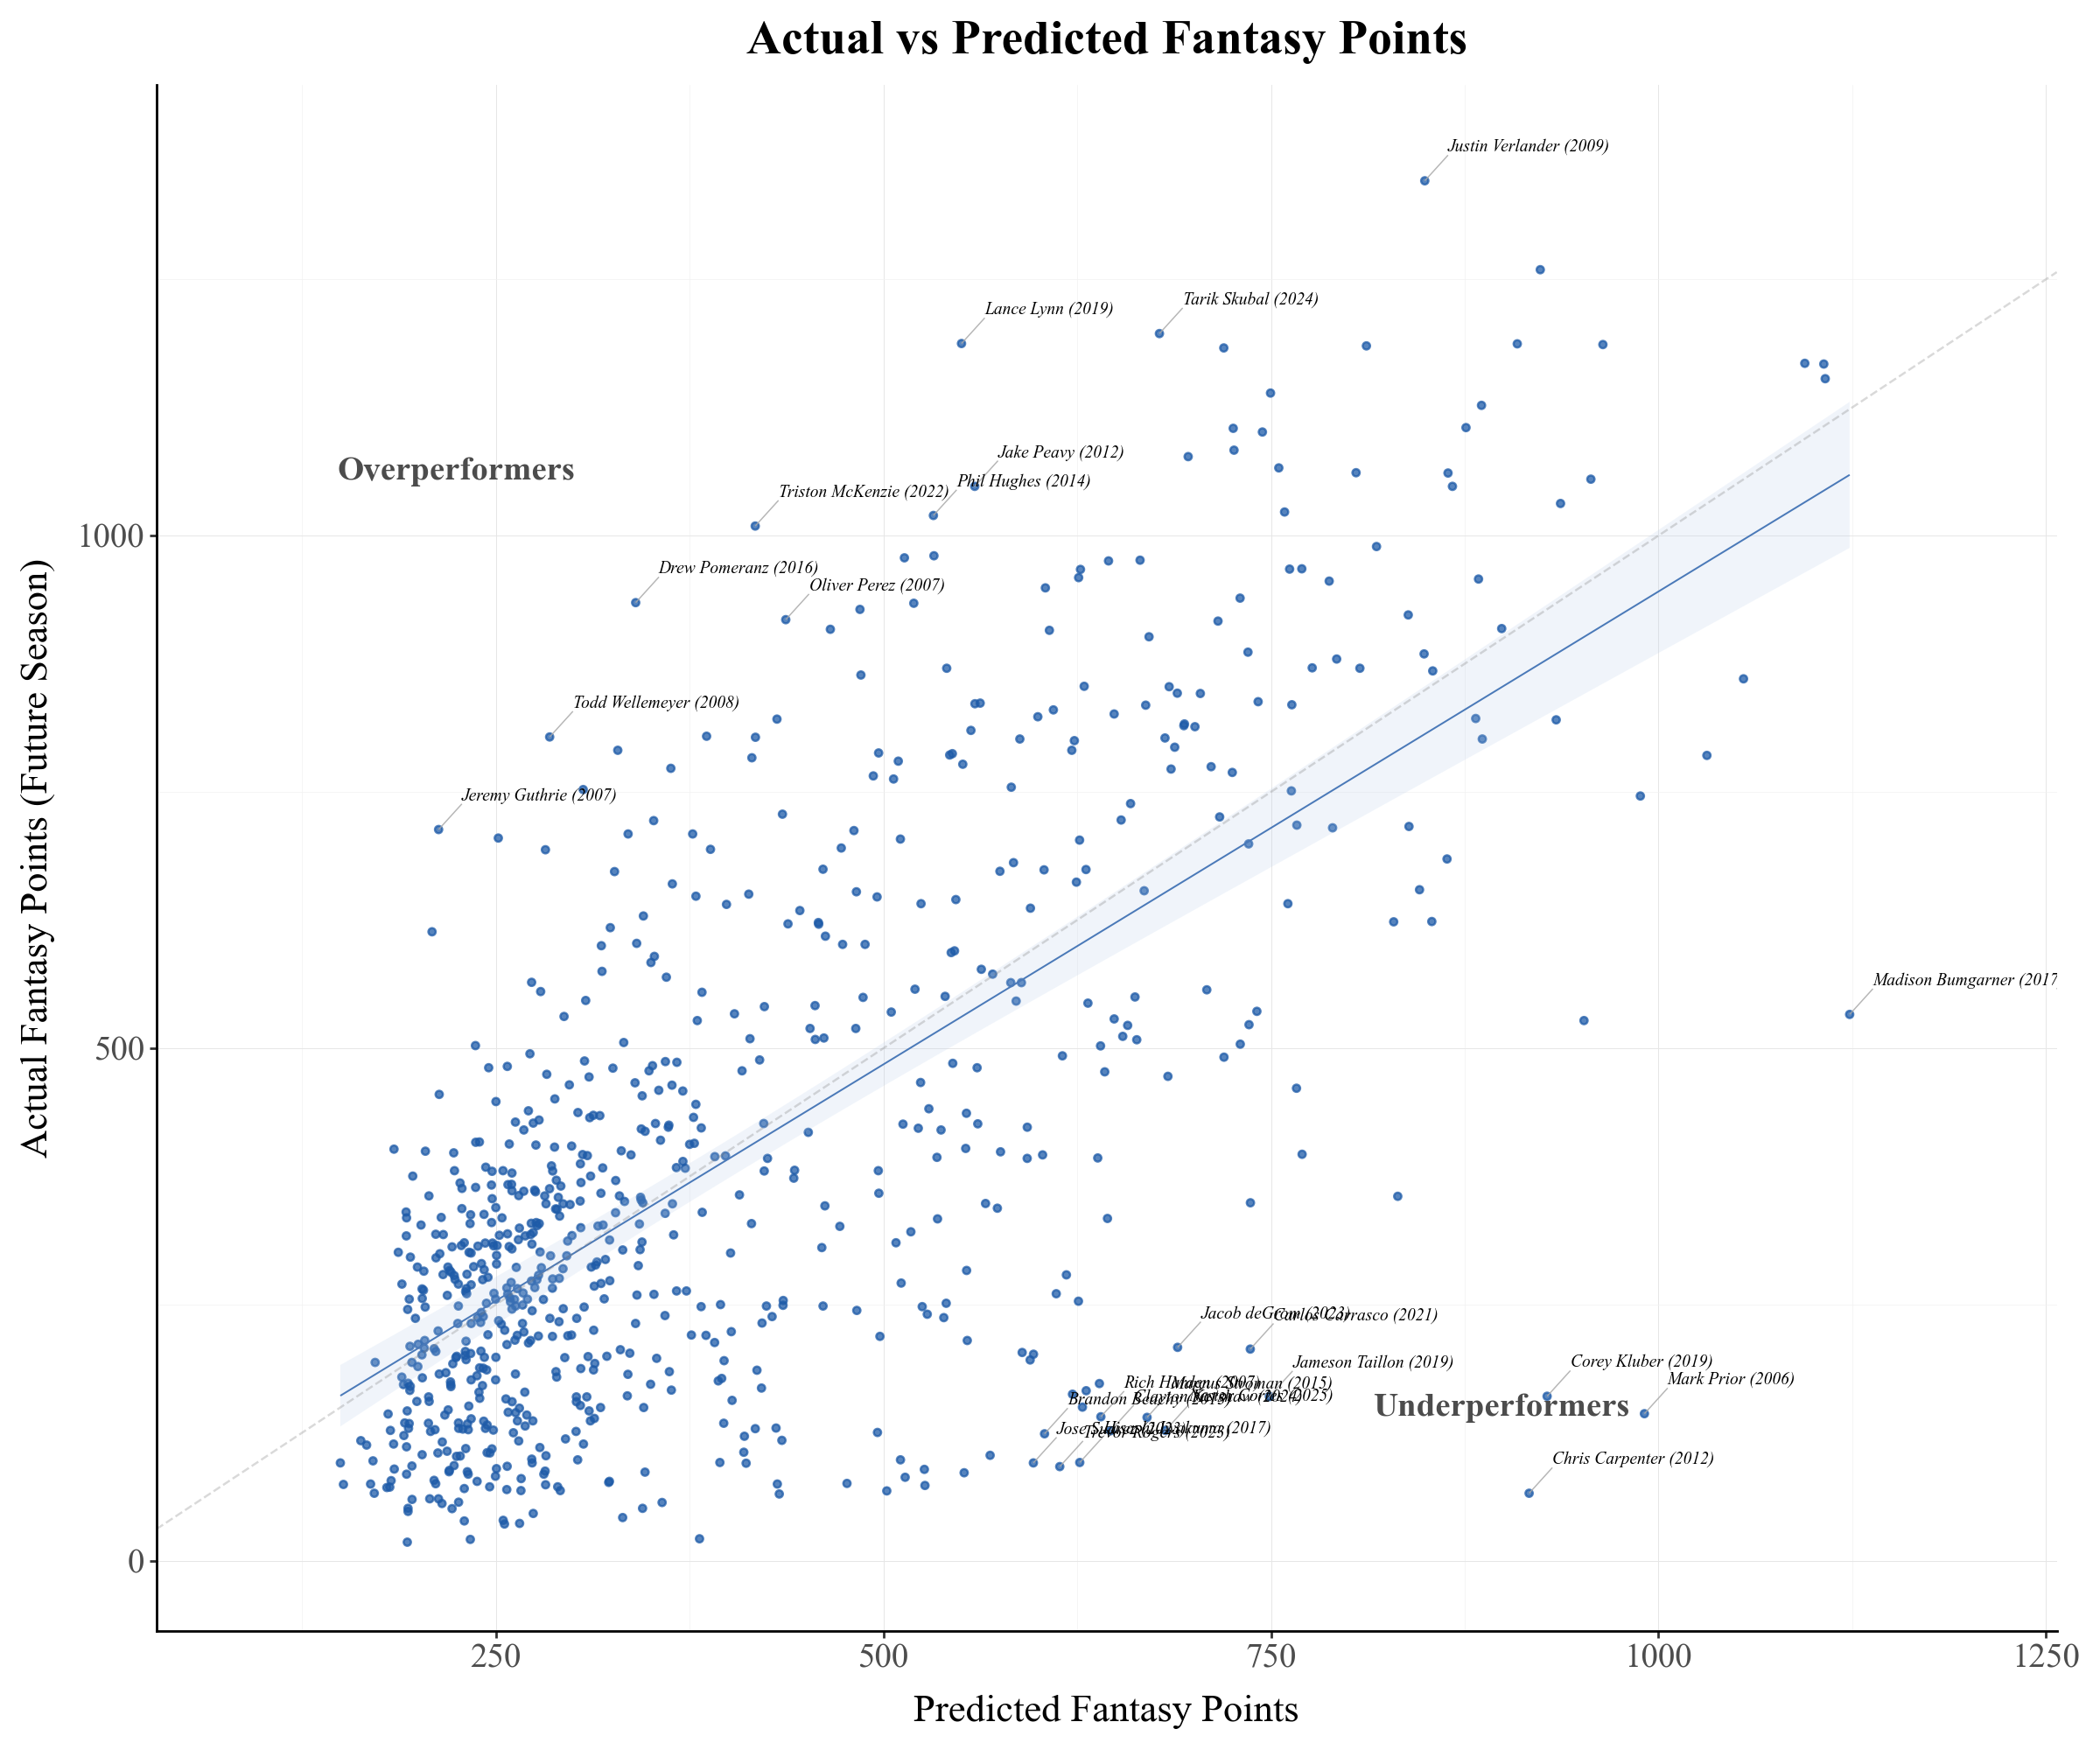

In [ ]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

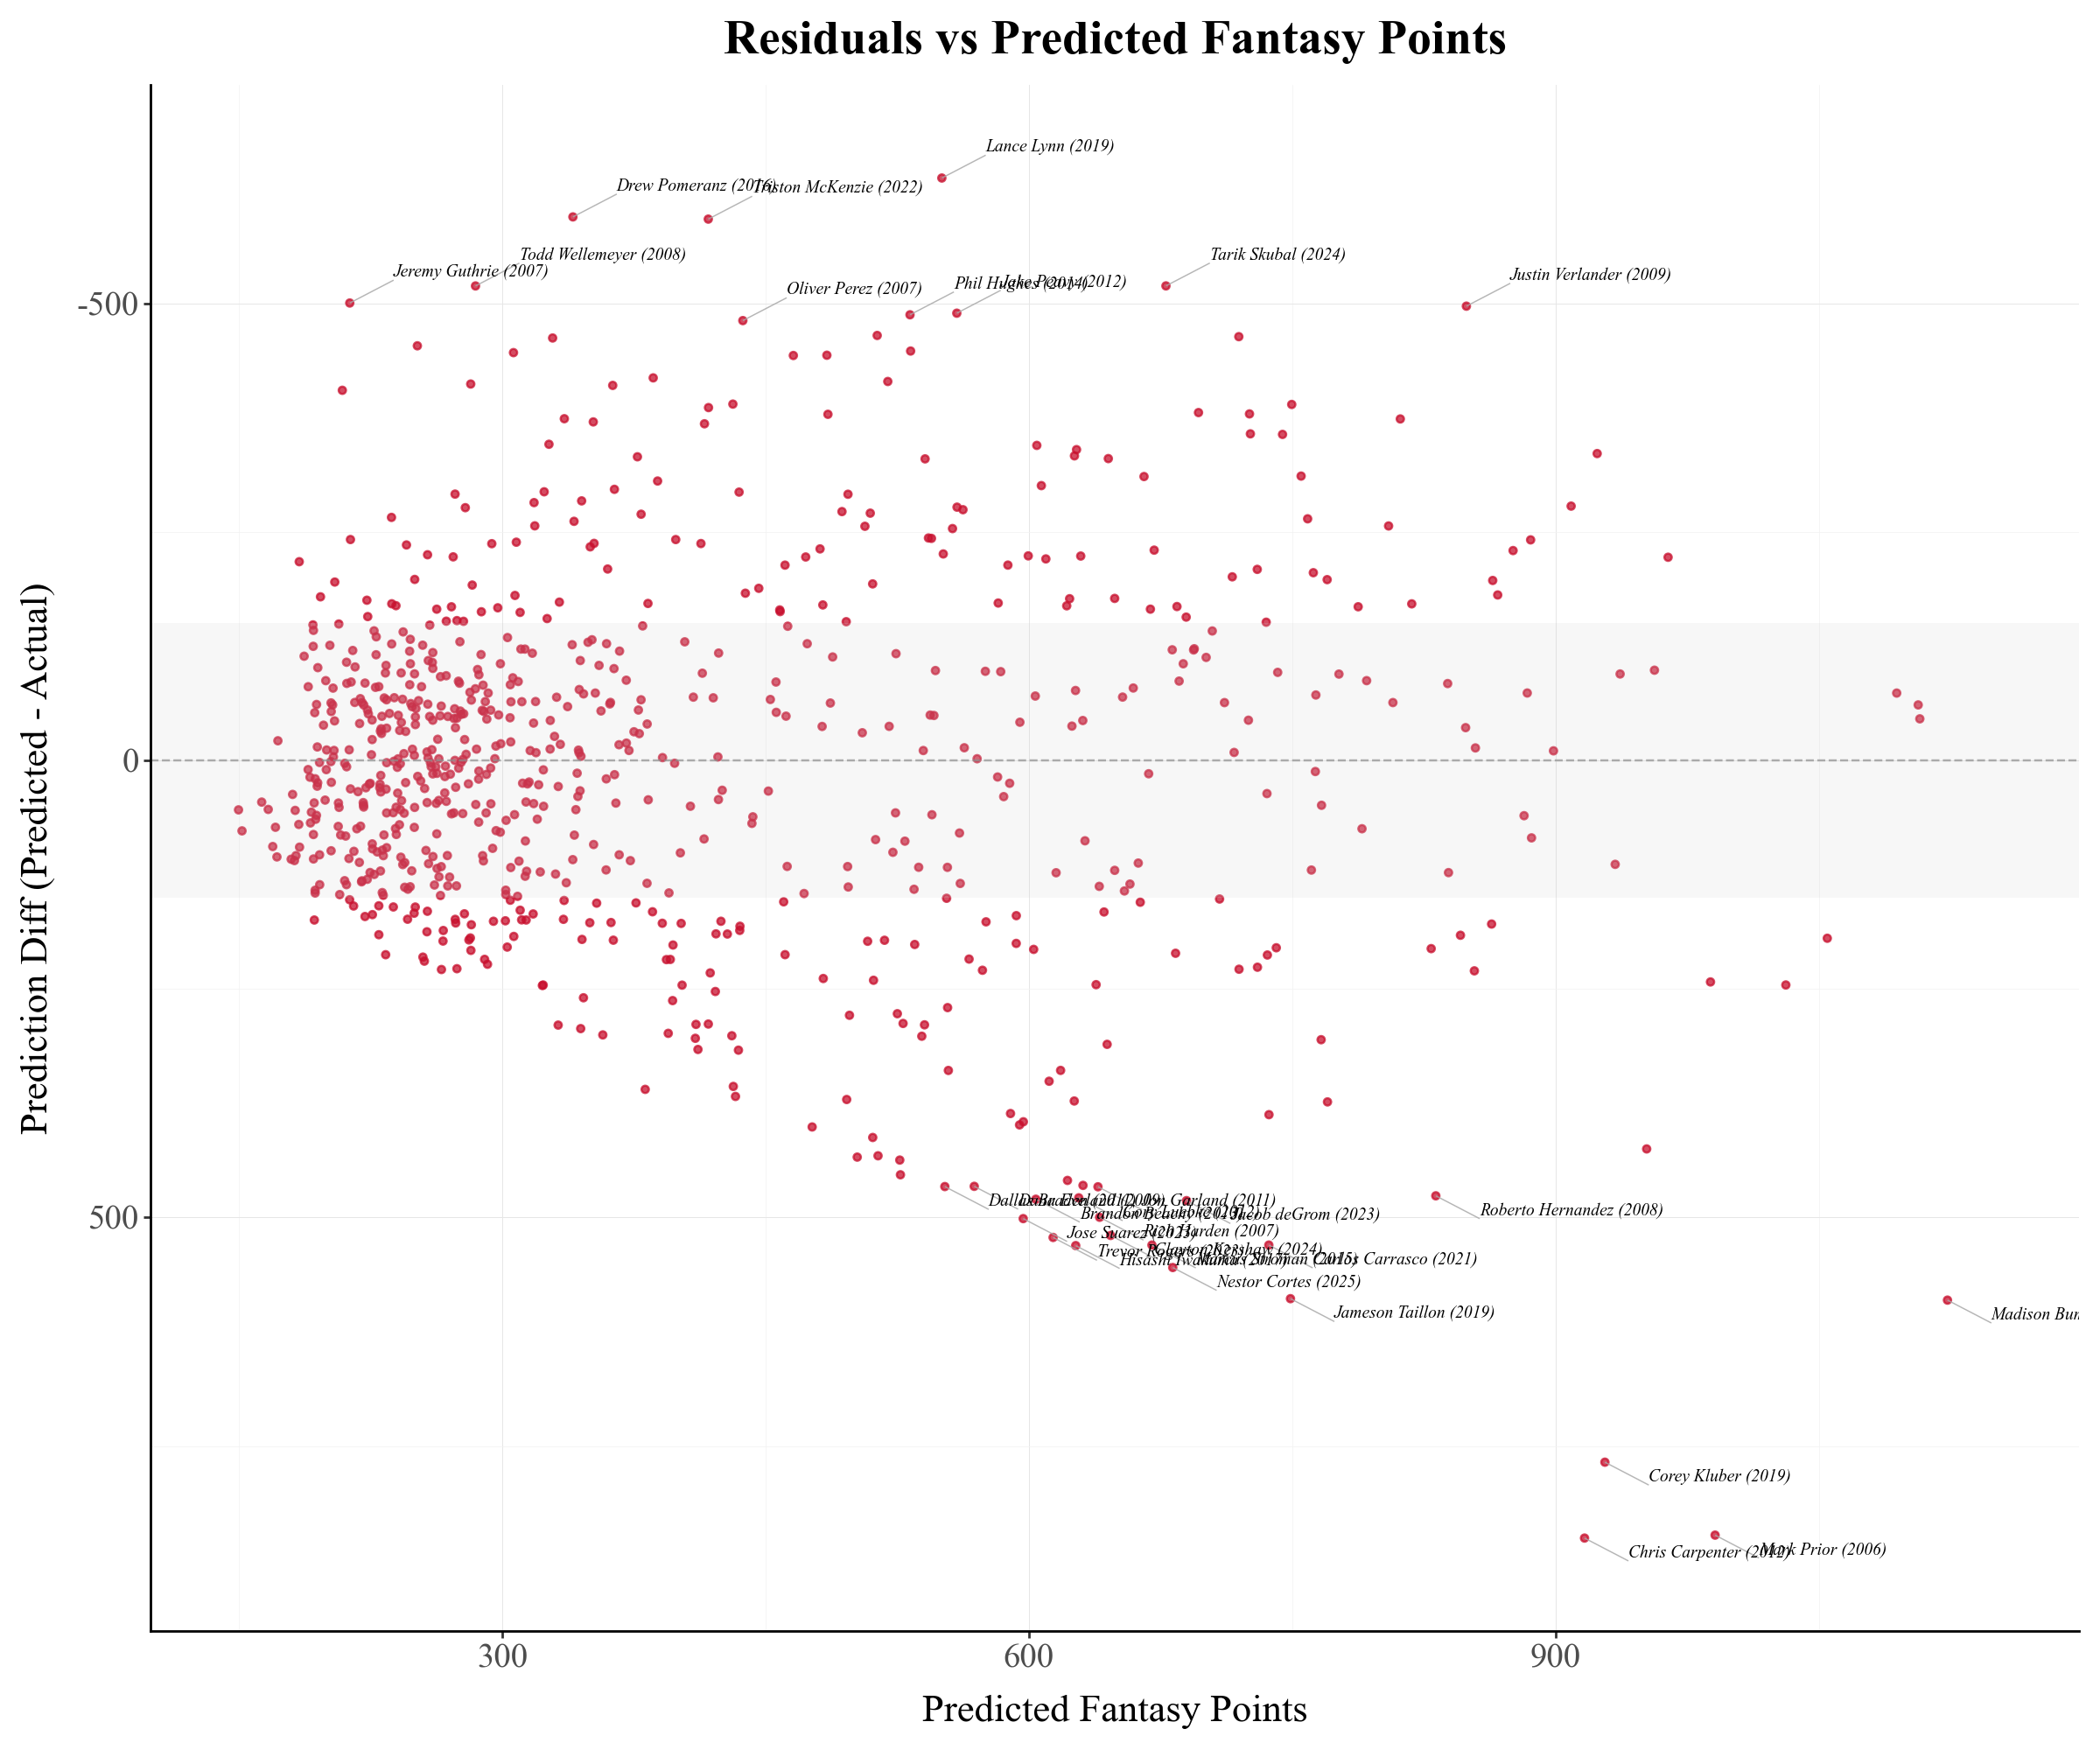

In [ ]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=150,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

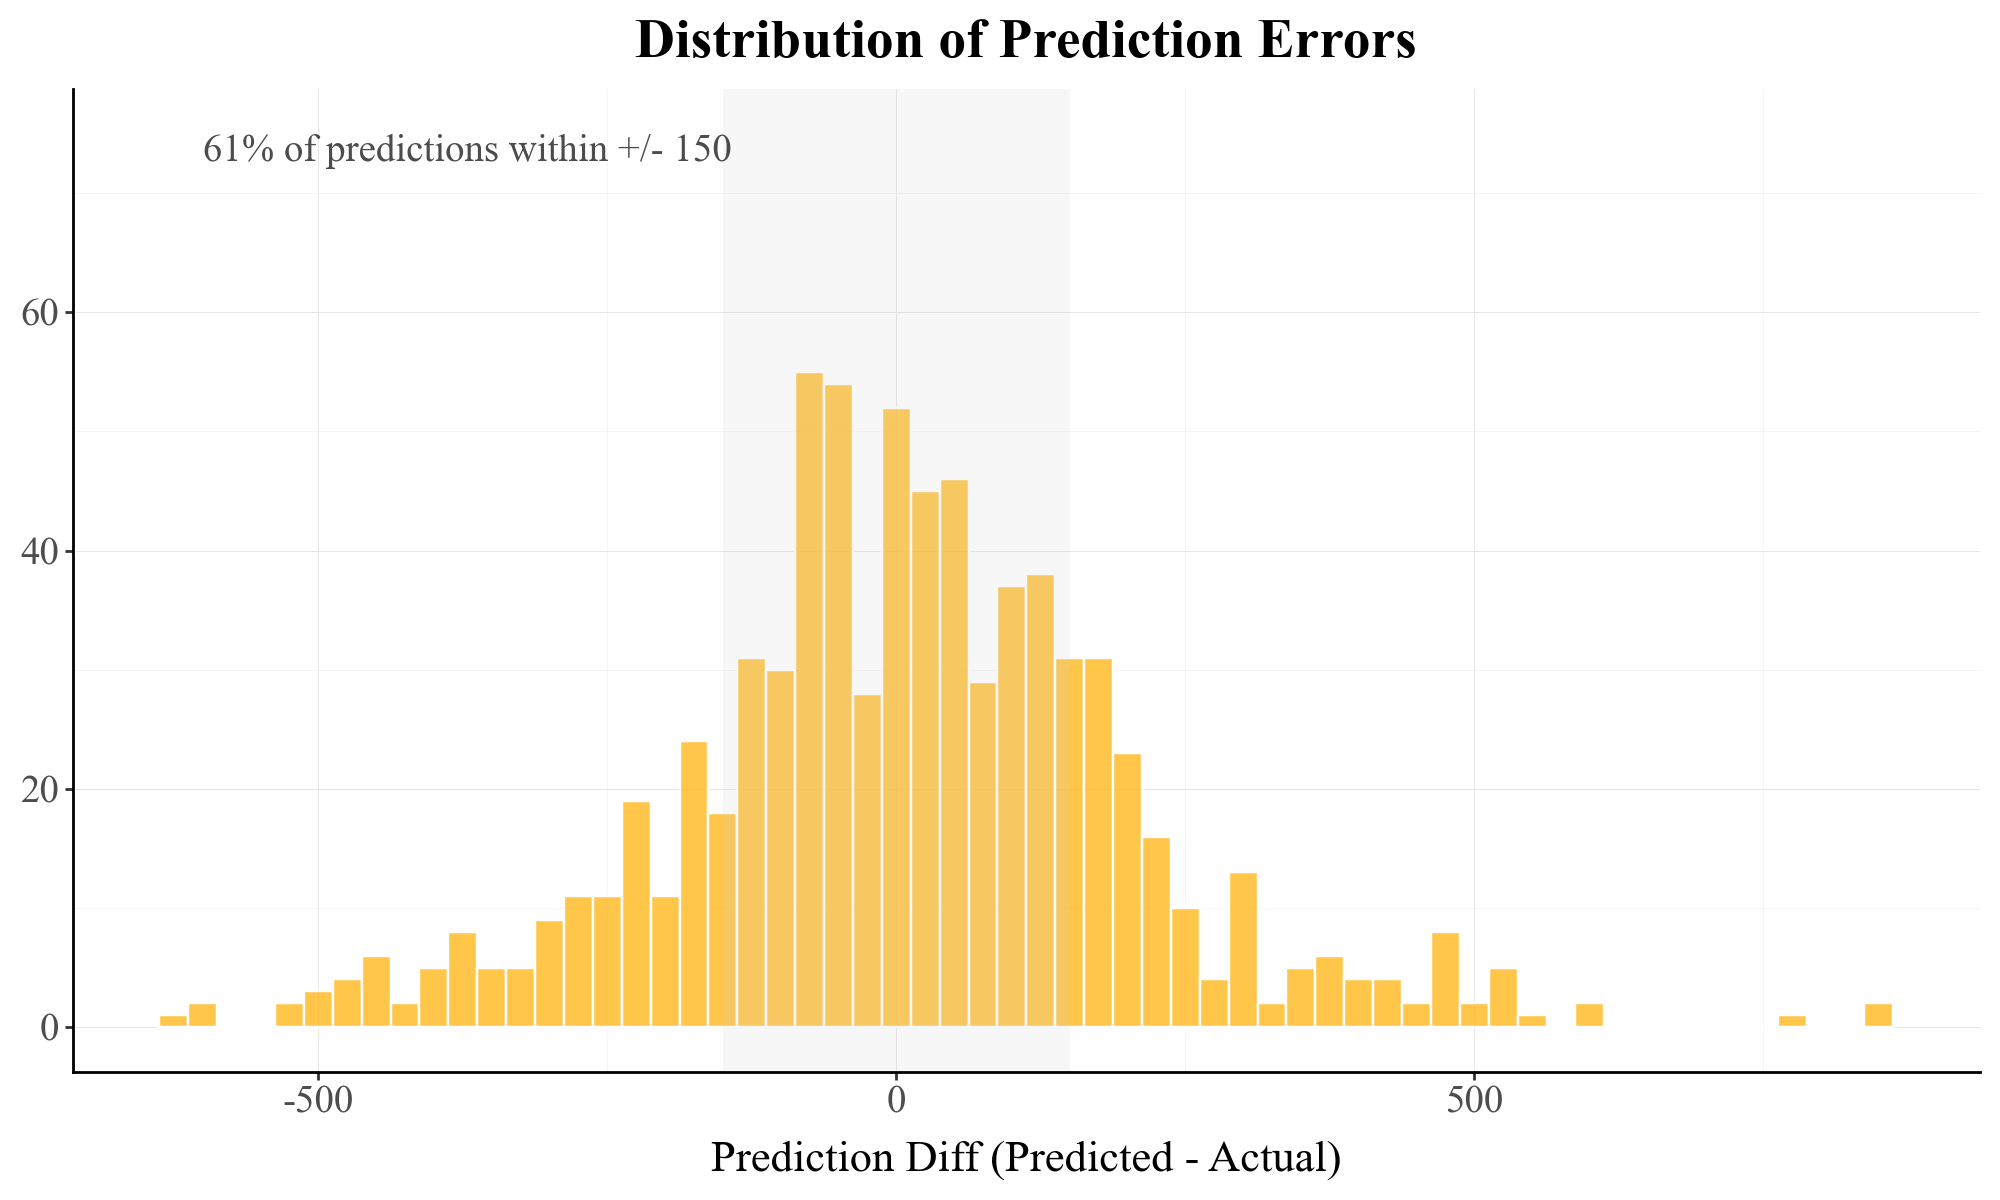

In [ ]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=150,
    binwidth=25,
    x_annotate=-600,    # custom annotation position
    y_annotate=75,      # custom annotation position
)
p3.show()

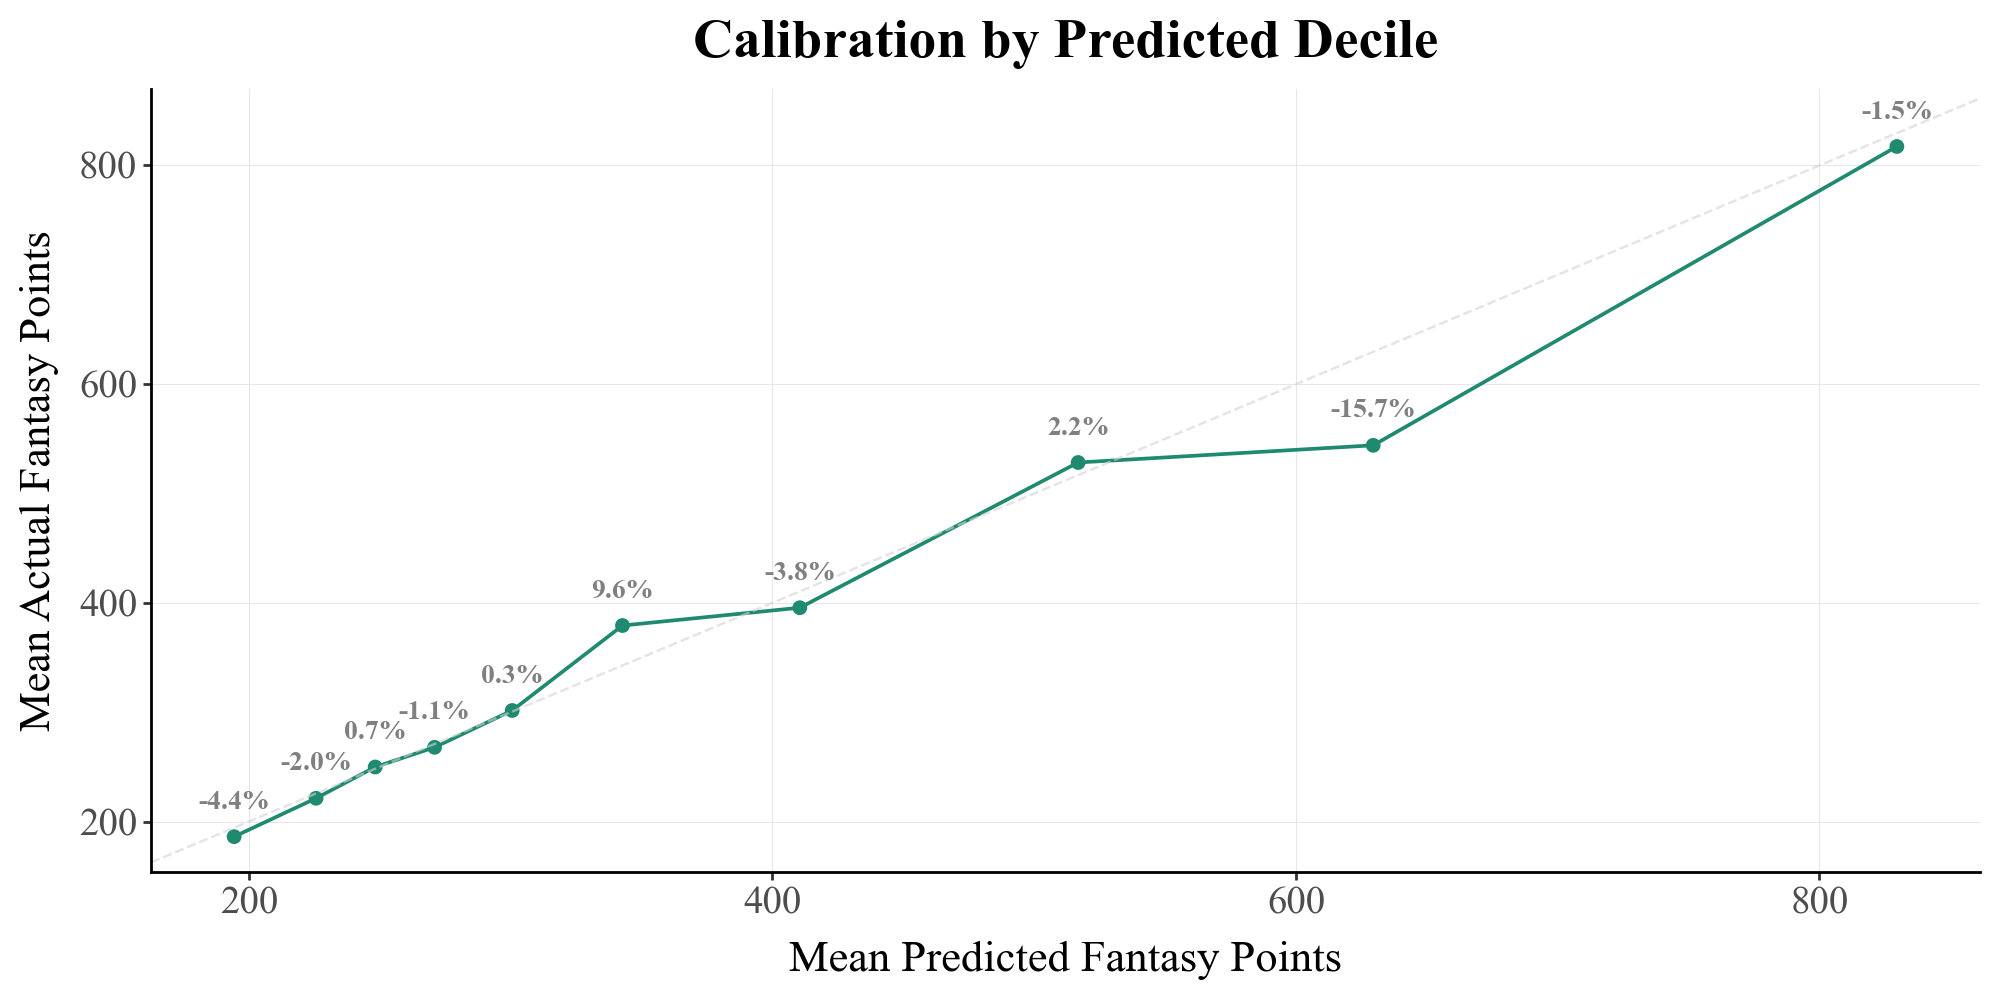

In [ ]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [ ]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_pred['fantasy_points_pred'] = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_pred['fantasy_points_pred'] = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

# Merge intervals onto pred dataframes
batting_pred = batting_pred.merge(
    batting_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

pitching_pred = pitching_pred.merge(
    pitching_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)

In [ ]:
display(batting_pred.head(5))

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,player_tier_recent,fantasy_points_pred,pred_mean,pred_p10,pred_p50,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80
228,20123,2025,Juan Soto,26,160,577,152,88,20,1,...,star,1708.831543,1483.025504,1167.449662,1469.552270,1892.650015,409.624510,315.575843,1.186505,725.200353
203,19755,2025,Shohei Ohtani,30,158,611,172,83,25,9,...,star,1670.979736,1561.207548,1206.924145,1540.977411,2082.303503,521.095955,354.283403,1.351714,875.379358
366,25764,2025,Bobby Witt Jr.,25,157,623,184,108,47,6,...,star,1553.387695,1483.339090,1176.317094,1426.037658,1884.610181,401.271092,307.021996,1.191816,708.293087
373,25878,2025,Corbin Carroll,24,143,564,146,66,32,17,...,star,1535.724243,1449.529465,1093.402170,1539.621160,1782.254995,332.725530,356.127296,0.863958,688.852825
108,16478,2025,Kyle Schwarber,32,162,604,145,64,23,2,...,above_avg,1524.755005,1185.905953,820.450007,1211.469346,1534.013520,348.107567,365.455946,0.894478,713.563513


In [ ]:
display(pitching_pred.head(5))

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,is_reliever,fantasy_points_pred,pred_mean,pred_p10,pred_p50,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80
186,17995,2025,Logan Webb,28,34,34,3282,2165,15,5.5,...,0,948.486450,914.821350,719.437851,898.498751,1139.397422,224.576072,195.383500,1.050993,419.959571
335,22267,2025,Tarik Skubal,28,31,31,2849,2003,13,6.6,...,0,947.001953,970.240743,738.020540,897.709679,1357.369467,387.128724,232.220203,1.538514,619.348927
24,10310,2025,Zack Wheeler,35,24,24,2394,1549,10,4.0,...,0,878.424255,825.750103,593.000399,814.528172,1051.686789,225.936686,232.749704,0.906413,458.686390
195,18525,2025,Dylan Cease,29,32,32,3046,1925,8,3.4,...,0,866.195923,787.113104,561.542852,780.068876,1052.186581,265.073478,225.570251,1.098466,490.643729
296,21390,2025,Joe Ryan,29,31,30,2798,1832,13,3.1,...,0,865.116089,762.563748,523.771724,764.604608,1003.562344,240.998596,238.792024,0.948652,479.790620


In [ ]:
# Splitting names into first and last
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80,first_name,last_name,Team,Positions,projected_fantasy_points
509,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,1203.128990,385.908164,478.855526,0.779298,864.763690,max,muncy,LAD,3B,903.0
510,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,1203.128990,385.908164,478.855526,0.779298,864.763690,max,muncy,ATH,"2B,3B,SS",633.0
511,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,884.516094,389.578539,466.908687,0.817056,856.487226,max,muncy,LAD,3B,903.0
512,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,884.516094,389.578539,466.908687,0.817056,856.487226,max,muncy,ATH,"2B,3B,SS",633.0


In [ ]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

In [ ]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80,first_name,last_name,Team,Positions,projected_fantasy_points
594,6984.0,2025.0,Luis Garcia,38.0,58.0,0.0,896.0,572.0,2.0,0.7,...,454.129418,230.982626,243.854832,0.93019,474.837458,luis,garcia,NYM,RP,261.6
595,6984.0,2025.0,Luis Garcia,38.0,58.0,0.0,896.0,572.0,2.0,0.7,...,454.129418,230.982626,243.854832,0.93019,474.837458,luis,garcia,NaN,SP,160.6


In [ ]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

# Finalizing Predictions & Creating Relative Positional Value Scores

In [ ]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

batting_final = finalize_predictions(batting_final, mode="bat")
pitching_final = finalize_predictions(pitching_final, mode="pit")

In [ ]:
# Adjusting positional group for select players within the batting_final dataframe to align with 2026 position designations
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Rafael Devers', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Tyler Soderstrom', 'Position'] = 'OF'

# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [ ]:
# Creating final projected score, with a blended weight combining model and expert projections
# Creating initial player rankings based on final projection
# Filtering to player pool based on position
batting_final_if = (
    batting_final_if
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=batter_pool_if,
    )
)

batting_final_of = (
    batting_final_of
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=batter_pool_of,
    )
)

pitching_final = (
    pitching_final
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=pitcher_pool,
    )
)

batting_final = pd.concat([batting_final_if, batting_final_of])

# Assigning player position groups
batting_final = assign_position_group(batting_final, position_col = 'Position')
pitching_final = assign_position_group(pitching_final, position_col = 'Position')

# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

# Setting missing values in the implied_upside column to 1
combined_df['implied_upside'] = combined_df['implied_upside'].fillna(1)

In [ ]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.67,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

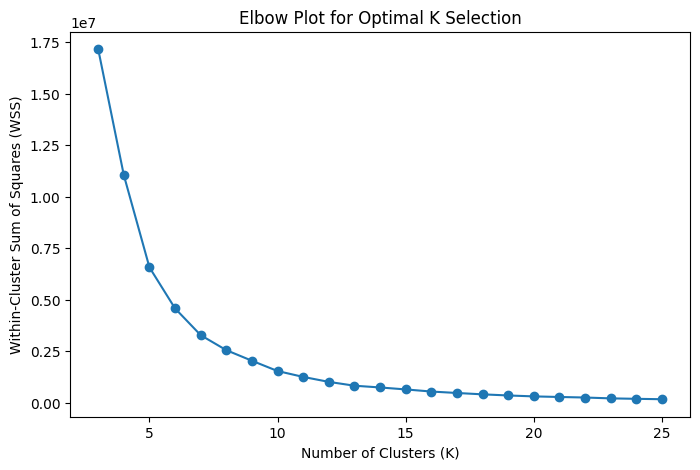

In [ ]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [ ]:
# Setting a K value and placing players into relative value tiers
final_df = segment_players(value_df, k = 19)

In [ ]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'pred_downside', 'pred_upside', 'implied_upside', 'relative_value',  
                     'overall_ranking', 'position_rank', 'player_value_tier']]

In [ ]:
# Saving out final dataframe
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}_{FORMAT}.csv', index=False)